In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


On a donc 1 an et 1 semaine de donnée

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Exploration

### Exploration des features

In [7]:
generator = (x for x in df)

In [92]:
col = next(generator)
print(col)
print(df[col].value_counts())
print(len(df[df[col].isnull()]))
print(df[col].describe())

StockCode
85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
20725     1359
22720     1232
POST      1196
20727     1126
22197     1118
23203     1115
22383     1103
21212     1080
23209     1040
23298     1036
22086     1029
22382     1021
20728     1012
22457      997
22469      996
22384      977
22960      974
21034      955
22727      932
23206      907
82482      905
22386      903
22993      902
22138      894
22666      890
          ... 
22146        1
90122B       1
85109        1
84550        1
90187B       1
90190B       1
44242A       1
84802A       1
84387A       1
90100        1
90025F       1
77079        1
90038A       1
90102        1
85224        1
90176B       1
90026A       1
84877A       1
84539        1
90104        1
37491B       1
20892        1
21414        1
17028J       1
84795C       1
23449        1
21412        1
37379A       1
90011A       1
84551        1
Name: StockCode, Length: 3684, dtype: int64
0
count     406825
unique      

### Gestion des invoice cancelled ou non

In [9]:
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)

In [10]:
#print(df[df["Cancelled"] == False][["InvoiceNo", "Cancelled"]])
#df[["InvoiceNo", "Cancelled"]]

In [11]:
df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')
# df['test'] = df['test'].astype(int)

### Gestion CustomerID

In [12]:
#df['CustomerID'] = df['CustomerID'].astype('int')
df[df['CustomerID'].isnull()]["Country"].value_counts()

United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: Country, dtype: int64

### Panier moyen

In [13]:
print(len(df[df["Cancelled"] == False]['InvoiceNo'].unique()))

22064


A partir du dataset initial, on crée un second dataset pour faire le RFM

In [14]:
def create_light_DF(regenerate = True):
    df2 = df.copy()
    now = df2["InvoiceDate"].max()
    print(now)
    first = df2["InvoiceDate"].min()
    print(first)
    if regenerate:
        df2 = df2[df2["Cancelled"] == False]
        df2["Price"] = df2["Quantity"].multiply(df2["UnitPrice"], axis="index")
        newDF = df2.groupby('InvoiceNo').agg({
            'Price': 'sum',
            'Quantity': 'sum', 
            'CustomerID': lambda x: x.iloc[0],
            'Country': lambda x: x.iloc[0],
            'InvoiceDate': lambda x: x.iloc[0]
            })
        newDF["Recency"] = now-newDF["InvoiceDate"]
        newDF["Recency"] = pd.to_timedelta(newDF["Recency"]).astype("timedelta64[D]")
        return newDF
    else:
        newDF = pd.read_csv("new_DF.csv")
        newDF["InvoiceDate"] = pd.to_datetime(newDF["InvoiceDate"])
        return newDF

In [15]:
newDF = create_light_DF(True)

2011-12-09 12:50:00
2010-12-01 08:26:00


In [16]:
newDF

,Price,Quantity,CustomerID,Country,InvoiceDate,Recency
InvoiceNo,,,,,,
536365,139.12,40,17850.0,United Kingdom,2010-12-01 08:26:00,373.0
536366,22.20,12,17850.0,United Kingdom,2010-12-01 08:28:00,373.0
536367,278.73,83,13047.0,United Kingdom,2010-12-01 08:34:00,373.0
536368,70.05,15,13047.0,United Kingdom,2010-12-01 08:34:00,373.0
536369,17.85,3,13047.0,United Kingdom,2010-12-01 08:35:00,373.0
536370,855.86,449,12583.0,France,2010-12-01 08:45:00,373.0
536371,204.00,80,13748.0,United Kingdom,2010-12-01 09:00:00,373.0
536372,22.20,12,17850.0,United Kingdom,2010-12-01 09:01:00,373.0
536373,259.86,88,17850.0,United Kingdom,2010-12-01 09:02:00,373.0


count     18536.000000
mean        480.758217
std        1678.028528
min           0.000000
25%         157.930000
50%         303.020000
75%         471.660000
max      168469.600000
Name: Price, dtype: float64


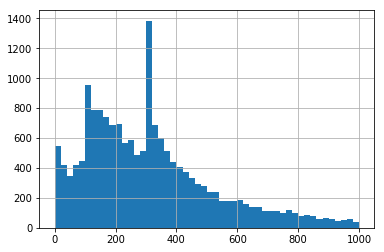

In [40]:
print(newDF["Price"].describe())
newDF["Price"].hist(range = (0, 1000), bins=50)

In [18]:
newDF["Price"]

InvoiceNo
536365     139.12
536366      22.20
536367     278.73
536368      70.05
536369      17.85
536370     855.86
536371     204.00
536372      22.20
536373     259.86
536374     350.40
536375     259.86
536376     328.80
536377      22.20
536378     444.98
536380      34.80
536381     449.98
536382     430.60
536384     489.60
536385     130.85
536386     508.20
536387    3193.92
536388     226.14
536389     358.25
536390    1825.74
536392     318.14
536393      79.60
536394    1024.68
536395     507.88
536396     376.36
536397     279.00
           ...   
581491      19.80
581492    7689.23
581493     208.64
581494     339.14
581495    1203.90
581496     598.97
581497    3217.20
581498    5664.89
581500     103.30
581501     485.00
581502     133.35
581514     200.99
581516     382.01
581538     197.09
581566     469.44
581567     389.21
581570     224.95
581571     494.60
581572     250.52
581574     277.08
581578     848.55
581579     903.62
581580      94.11
581581      51.18


On a un prix de vente negatif, il faut donc creuser

In [19]:
newDF[newDF["Price"] < 0]

,Price,Quantity,CustomerID,Country,InvoiceDate,Recency
InvoiceNo,,,,,,
563186,-11062.06,1,NaN,United Kingdom,2011-08-12 14:51:00,118.0
563187,-11062.06,1,NaN,United Kingdom,2011-08-12 14:52:00,118.0


In [20]:
neg_price = list(newDF[newDF["Price"] < 0].index)

In [21]:
for inv in neg_price:
    print(df[df["InvoiceNo"] == int(inv)])

        InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983     563186         B  Adjust bad debt         1 2011-08-12 14:51:00   

        UnitPrice  CustomerID         Country  Cancelled  
299983  -11062.06         NaN  United Kingdom      False  
        InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299984     563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  Cancelled  
299984  -11062.06         NaN  United Kingdom      False  


C'est un remboursement' d'un trop payé. Comme on n'a pas le prix payé, on peut supprimer les lignes. On voit aussi que c'est un client inconnu donc surement le proprietaire du magasin. On peut regarder

In [22]:
df[df["CustomerID"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,False
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,False
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,False
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,False
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,False
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom,False
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,False
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom,False
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom,False
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom,False


On remarque que ce sont souvent des gros achat d'un coup par periode. C'est surement pour decorer le magasin (par exemple a Noel). On va donc aussi supprimer ces lignes. On voit aussi au passage que le 1er item n'a pas de description, il faut donc jeter un coup d'oeil

In [23]:
df[df["Description"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,False
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,False
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,False
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,False
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,False
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,False
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,False
2025,536553,37461,NaN,3,2010-12-01 14:35:00,0.0,NaN,United Kingdom,False
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.0,NaN,United Kingdom,False
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,False


Que des objets sans prix donc surement des erreurs de saises en plus venant du proprietaire du magasin. On va donc les supprimer aussi

In [24]:
df = df[df["CustomerID"].notnull()]
df = df[df["Description"].notnull()]

On regénère donc le nouveau dataset avec les prix et continuer l'exploration

2011-12-09 12:50:00
2010-12-01 08:26:00
count     18536.000000
mean        480.762187
std        1678.029352
min           0.000000
25%         157.930000
50%         303.020000
75%         471.660000
max      168469.600000
Name: Price, dtype: float64


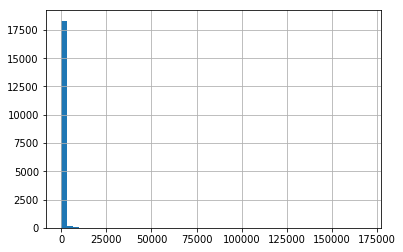

In [25]:
newDF = create_light_DF(True)
print(newDF["Price"].describe())
newDF["Price"].hist(bins=50)

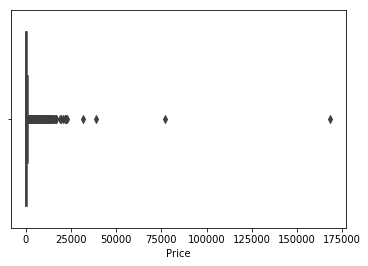

In [26]:
sns.boxplot(x=newDF["Price"])

On va retirer les outlier (les vente au dela de la moyenne + 5 fois la stdev). Cela concerne 51 offres seulement sur 400000+

In [27]:
seuil = newDF["Price"].mean() + 5*newDF["Price"].std()
len(newDF[newDF["Price"]>seuil])
tid = list(newDF[newDF["Price"]>seuil].index)
print(tid)

[537657, 537659, 540689, 540815, 541206, 541220, 541431, 543989, 544479, 545475, 546789, 547708, 548011, 550461, 552883, 552978, 553368, 553546, 554366, 554827, 555920, 556255, 556444, 556726, 556917, 558262, 558526, 560445, 561633, 561901, 562439, 562789, 563074, 563076, 563590, 563614, 566934, 567280, 567381, 567423, 569570, 569650, 569815, 572035, 572209, 573153, 578305, 580727, 581175, 581457, 581483]


In [28]:
for each in tid:
    df = df[df.index != int(each)]

In [29]:
newDF = create_light_DF(regenerate = True)

2011-12-09 12:50:00
2010-12-01 08:26:00


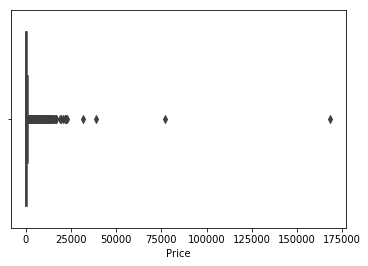

In [30]:
sns.boxplot(x=newDF["Price"])

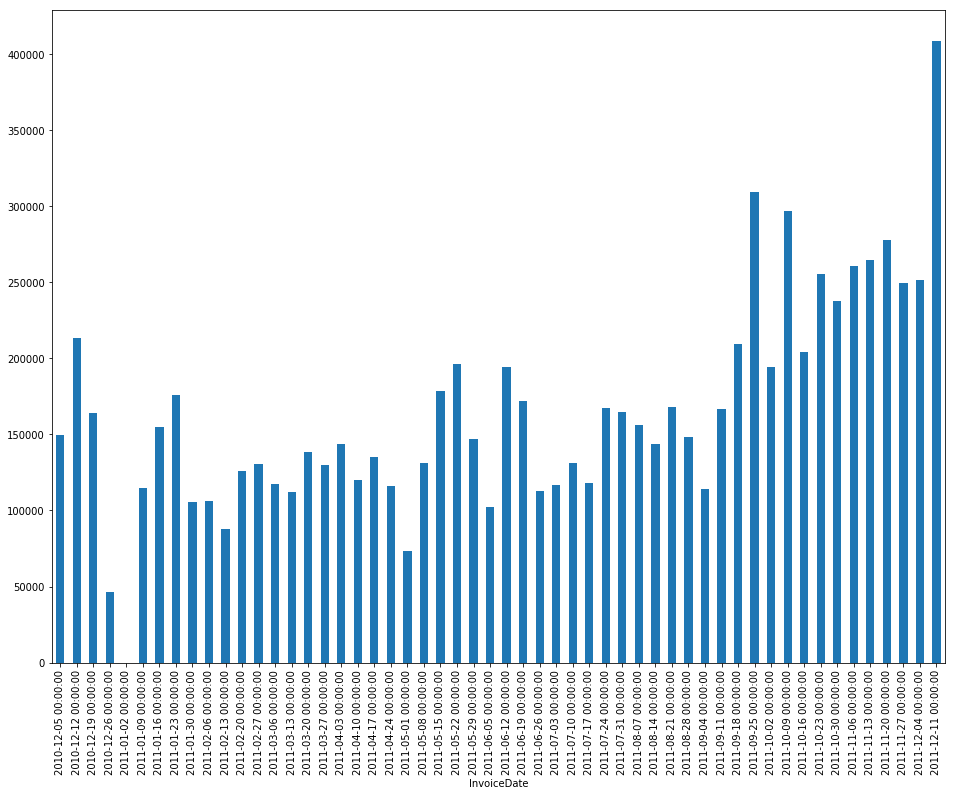

In [31]:
# newDF.groupby(pd.Grouper(key='InvoiceDate', freq='D'))["Price"].sum().unstack()
newDF.resample('W', on='InvoiceDate')['Price'].sum().fillna(0).plot(kind="bar", figsize=(16,12))  #http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

In [32]:
CA_per_countries = newDF.groupby(["Country"])["Price"].sum().sort_values()

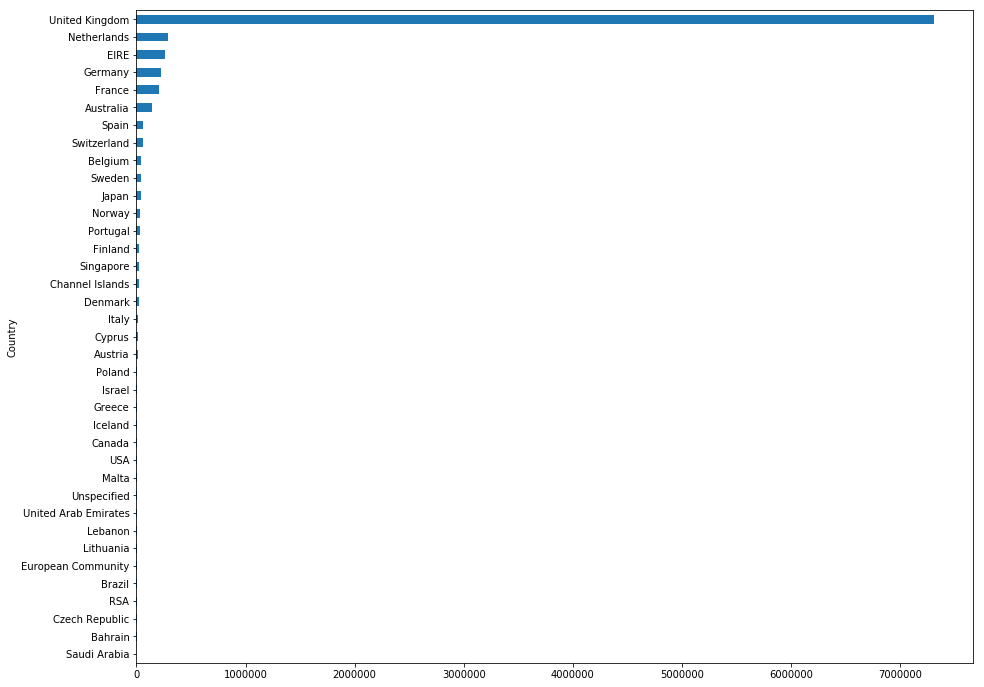

In [33]:
CA_per_countries.plot(kind='barh', figsize=(15,12))
plt.show()

In [34]:
CA_per_countries["United Kingdom"]/CA_per_countries.sum()

0.82011771803011924

In [35]:
print(list(CA_per_countries.index[::-1]))

['United Kingdom', 'Netherlands', 'EIRE', 'Germany', 'France', 'Australia', 'Spain', 'Switzerland', 'Belgium', 'Sweden', 'Japan', 'Norway', 'Portugal', 'Finland', 'Singapore', 'Channel Islands', 'Denmark', 'Italy', 'Cyprus', 'Austria', 'Poland', 'Israel', 'Greece', 'Iceland', 'Canada', 'USA', 'Malta', 'Unspecified', 'United Arab Emirates', 'Lebanon', 'Lithuania', 'European Community', 'Brazil', 'RSA', 'Czech Republic', 'Bahrain', 'Saudi Arabia']


In [36]:
decoder_countries = {i: j for i, j in enumerate(CA_per_countries.index[::-1]) }
encoder_countries = {j: i for i, j in enumerate(CA_per_countries.index[::-1]) }

18 % des revenus sont étrangers

Le dataset a l'air plus clean, on peut donc le sauvegarder

In [91]:
df.to_csv("Online_Retail_clean.csv")

In [37]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,False
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,False
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,False
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,False
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,False


# Modélisation

Afin d'effectuer le clustering, on va réutiliser le principe du RFM mais avec plus de features. On peut notament penser à :

<li>Panier Moyen par visite</li>
<li>Nombre d'article moyen par visite</li>
<li>Durée moyenne entre les visites</li>
<li>Dernière visite</li>
<li>Nombre de visite</li>
<li>Pays</li>

In [148]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict, Counter

In [163]:
newDF = pd.read_csv("new_DF.csv")

In [164]:
newDF["InvoiceDate"] = pd.to_datetime(newDF["InvoiceDate"])

In [165]:
newDF["Country"] = newDF["Country"].apply(lambda x:encoder_countries[x])

In [166]:
newDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18485 entries, 0 to 18484
Data columns (total 7 columns):
Country           18485 non-null int64
CustomerID        18485 non-null float64
InvoiceDate       18485 non-null datetime64[ns]
InvoiceNo         18485 non-null float64
Number_article    18485 non-null float64
Price             18485 non-null float64
Recency           18485 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1011.0 KB


In [167]:
# newDF.drop("InvoiceDate", axis=1, inplace=True)
newDF.drop("InvoiceNo", axis=1, inplace=True)

In [168]:
newDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18485 entries, 0 to 18484
Data columns (total 6 columns):
Country           18485 non-null int64
CustomerID        18485 non-null float64
InvoiceDate       18485 non-null datetime64[ns]
Number_article    18485 non-null float64
Price             18485 non-null float64
Recency           18485 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 866.6 KB


In [169]:
newDF["freq"] = 0
newDF["nb_visits"] = 0

In [189]:
rfmTable = newDF.groupby(['CustomerID']).agg({
    'Recency': ['min', "max"], 
    'Number_article': ["sum", "mean"],
    "Price": ['sum', "mean"],
    "Country" : "mean",
    "freq" : "mean",
    "nb_visits" : "count"
}).reset_index()

In [190]:
rfmTable["freq"] = (rfmTable["Recency"]["max"] - rfmTable["Recency"]["min"]) / rfmTable["nb_visits"]["count"]

In [219]:
a = pd.DataFrame(rfmTable.to_records())
a.drop(["index"], axis=1, inplace=True)
a = a.set_index("('CustomerID', '')")

,"('Recency', 'min')","('Recency', 'max')","('Number_article', 'sum')","('Number_article', 'mean')","('Price', 'sum')","('Price', 'mean')","('Country', 'mean')","('freq', 'mean')","('nb_visits', 'count')"
"('CustomerID', '')",,,,,,,,,
12347.0,1.0,366.0,182.0,26.000000,4310.00,615.714286,23.00,52.142857,7
12348.0,74.0,357.0,31.0,7.750000,1797.24,449.310000,13.00,70.750000,4
12349.0,18.0,18.0,73.0,73.000000,1757.55,1757.550000,17.00,0.000000,1
12350.0,309.0,309.0,17.0,17.000000,334.40,334.400000,11.00,0.000000,1
12352.0,35.0,296.0,85.0,10.625000,2506.04,313.255000,11.00,32.625000,8
12353.0,203.0,203.0,4.0,4.000000,89.00,89.000000,35.00,0.000000,1
12354.0,231.0,231.0,58.0,58.000000,1079.40,1079.400000,6.00,0.000000,1
12355.0,213.0,213.0,13.0,13.000000,459.40,459.400000,35.00,0.000000,1
12356.0,22.0,325.0,59.0,19.666667,2811.43,937.143333,12.00,101.000000,3


In [222]:
final_df = a[[
    "('Recency', 'min')", 
    "('Number_article', 'mean')", 
    "('Price', 'mean')", 
    "('Country', 'mean')", 
    "('freq', 'mean')", 
    "('nb_visits', 'count')"
]]
final_df.columns = ["Recency", "Avg_article", "Avg_Price", "Country", "Freq_visits", "nb_visits"]

In [230]:
final_df

,Recency,Avg_article,Avg_Price,Country,Freq_visits,nb_visits
0,1.0,26.000000,615.714286,23.00,52.142857,7
1,74.0,7.750000,449.310000,13.00,70.750000,4
2,18.0,73.000000,1757.550000,17.00,0.000000,1
3,309.0,17.000000,334.400000,11.00,0.000000,1
4,35.0,10.625000,313.255000,11.00,32.625000,8
5,203.0,4.000000,89.000000,35.00,0.000000,1
6,231.0,58.000000,1079.400000,6.00,0.000000,1
7,213.0,13.000000,459.400000,35.00,0.000000,1
8,22.0,19.666667,937.143333,12.00,101.000000,3
9,32.0,131.000000,6207.670000,7.00,0.000000,1


In [231]:
final_df.to_csv("final_df.csv", index=False)

# Mise en place du Clustering

In [45]:
final_df = pd.read_csv("final_df.csv")

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(final_df)

In [47]:
X_scaled

array([[ 0.00268097,  0.08760403,  0.07856004,  0.63888889,  0.28493365,
         0.02870813],
       [ 0.19839142,  0.02365309,  0.05732823,  0.36111111,  0.38661202,
         0.01435407],
       [ 0.04825737,  0.25229961,  0.2242488 ,  0.47222222,  0.        ,
         0.        ],
       ..., 
       [ 0.01876676,  0.01752081,  0.01135885,  0.        ,  0.32240437,
         0.00478469],
       [ 0.0080429 ,  0.16206746,  0.01670558,  0.        ,  0.11372951,
         0.07177033],
       [ 0.11260054,  0.0782596 ,  0.07814056,  0.        ,  0.28961749,
         0.00956938]])

### Kmeans

In [99]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="k-means++", n_clusters=5)
X_embedded = kmeans.fit_transform(X_scaled)

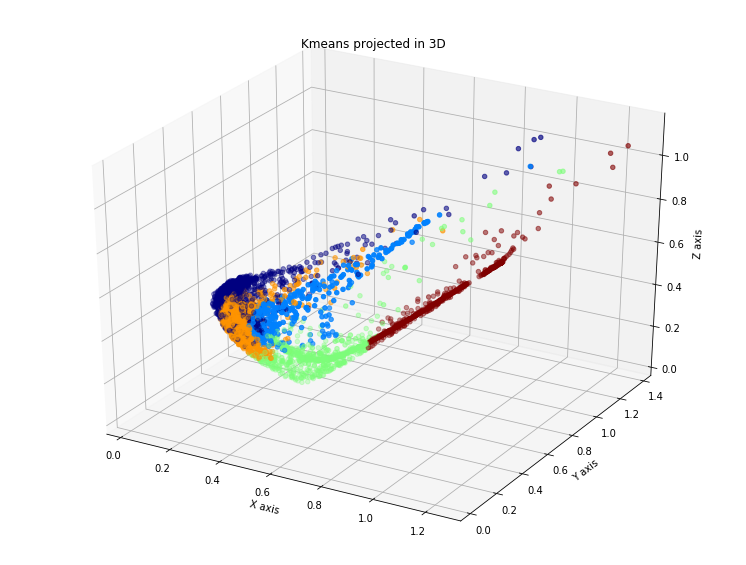

In [100]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=kmeans.labels_, cmap="jet")
plt.title("Kmeans projected in 3D")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("img/kmeans3d.png")
plt.show()

#### Exploration du résultat

In [101]:
final_df["label_kmeans"] = kmeans.labels_

In [102]:
def proportion(x):
    nb_abroad = x.astype(bool).sum(axis=0)
    nb_total = len(x)
    return (nb_total-nb_abroad)/nb_total

In [103]:
final_df.groupby("label_kmeans").agg({
    "Recency" : "mean",
    "Avg_article" : "mean",
    "Avg_Price" : "mean",
    "Country" : proportion,
    "Freq_visits" : "mean",
    "nb_visits" : "mean"
})

,Recency,Avg_article,Avg_Price,Country,Freq_visits,nb_visits
label_kmeans,,,,,,
0,32.324180,24.188176,409.048262,0.906899,9.615064,6.345613
1,47.528205,22.297650,343.569992,0.928205,110.795299,2.482051
2,168.632743,18.629588,334.345818,0.908555,17.332521,2.048673
3,35.901420,23.320097,384.295044,0.895572,51.297692,4.922306
4,298.239655,18.646046,320.641577,0.889655,2.706191,1.313793


### Clustering Hierarchique

In [105]:
from sklearn.cluster import AgglomerativeClustering

agg_cl = AgglomerativeClustering(n_clusters=5)
pos = agg_cl.fit_predict(X_scaled)

In [106]:
final_df["label_CH"] = pos

In [107]:
final_df.groupby("label_CH").agg({
    "Recency" : "mean",
    "Avg_article" : "mean",
    "Avg_Price" : "mean",
    "Country" : proportion,
    "Freq_visits" : "mean",
    "nb_visits" : "mean"
})

,Recency,Avg_article,Avg_Price,Country,Freq_visits,nb_visits
label_CH,,,,,,
0,36.577686,23.456899,384.375710,0.931405,21.706807,5.852066
1,175.664606,19.033079,323.551356,0.948995,26.772951,2.302937
2,39.916805,22.183250,338.203961,0.951747,95.313172,2.903494
3,300.516423,18.214793,319.780231,0.875912,2.055519,1.308394
4,51.114754,30.941117,814.213172,0.000000,33.013300,3.040984


### Mise en place des notes

Au lieu de juste regarder par note (comme dans l'exemple avec 111 - 112 etc..) on utilise un clustering du coup on ne mettra pas de note comme ici

In [57]:
# rfmTable = pd.read_csv("RFM.csv")
# rfmTable

In [58]:
# quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
# quantiles = quantiles.to_dict()

In [59]:
# print(quantiles)

In [60]:
# def RScore(x,p,d):
#     if x <= d[p][0.25]:
#         return 1
#     elif x <= d[p][0.50]:
#         return 2
#     elif x <= d[p][0.75]: 
#         return 3
#     else:
#         return 4
    
# def FMScore(x,p,d):
#     if x <= d[p][0.25]:
#         return 4
#     elif x <= d[p][0.50]:
#         return 3
#     elif x <= d[p][0.75]: 
#         return 2
#     else:
#         return 1
    
# def Proximity(x,p,d):
#     if x == d[p][0.5]:
#         return 1
#     else:
#         return 4

In [61]:
# segmented_rfm = rfmTable
# segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
# segmented_rfm['f_quartile'] = segmented_rfm['Number_article'].apply(FMScore, args=('Number_article',quantiles,))
# segmented_rfm['m_quartile'] = segmented_rfm['Price'].apply(FMScore, args=('Price',quantiles,))
# segmented_rfm['p_quartile'] = segmented_rfm['Country'].apply(Proximity, args=('Country',quantiles,))
# segmented_rfm.head()

In [62]:
# print(segmented_rfm["Country"].value_counts())
# print(segmented_rfm["p_quartile"].value_counts())

In [63]:
# plt.figure(figsize=(12,12))
# sns.boxplot(y="Recency", x="p_quartile", data=segmented_rfm)
# plt.show()

In [64]:
# plt.figure(figsize=(12,12))
# sns.boxplot(y="Number_article", x="p_quartile", data=segmented_rfm)
# plt.show()

In [65]:
# plt.figure(figsize=(12,12))
# sns.boxplot(y="Price", x="p_quartile", data=segmented_rfm)
# plt.show()

## Nouveau modèle post analyse